# Classification Models and Hyperparameter Finetuning

In [43]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier


### path and file

In [44]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [45]:
#importing model data
df_model=pd.read_csv(path_result+"/"+"model_after_feature_selection_historicl_features.csv", index_col=0)

### Split the data to tarin 80% and test 20% 

In [46]:
# Ensure the target column 'result' exists in the dataset
if 'result' in df_model.columns:
    # Define target
    y = df_model['result']
    
    # Define features by dropping the target column
    X = df_model.drop(columns=['result'])

    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Show the shapes of the resulting sets
    split_shapes = {
        "X_train": X_train.shape,
        "X_test": X_test.shape,
        "y_train": y_train.shape,
        "y_test": y_test.shape
    }
else:
    split_shapes = "❌ Column 'result' not found in dataset."

split_shapes


{'X_train': (10144, 27),
 'X_test': (2536, 27),
 'y_train': (10144,),
 'y_test': (2536,)}

### model run throw 8 calssification model  

In [47]:

# Classification metrics function
def classificationMetrics(y_true, y_pred, y_proba=None):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    result = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': precision,
        'Recall': recall,
        'f1-score': f1
    }

    if y_proba is not None:
        try:
            result['Log-loss'] = metrics.log_loss(y_true, y_proba)
            result['AUC'] = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
        except:
            result['Log-loss'] = None
            result['AUC'] = None
    else:
        result['Log-loss'] = None
        result['AUC'] = None

    return result


In [48]:
def get_feature_importance(model, feature_names):
    """
    Returns a sorted list of (feature_name, importance) tuples for a fitted model.
    
    Supports both tree-based models and linear models.
    """
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]  # for binary classification
        else:
            return None

        feature_importance = list(zip(feature_names, importances))
        return sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    except Exception:
        return None


In [49]:
### models run summarize

In [50]:


models_list = pd.DataFrame()
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ("SVM", SVC(probability=True)),
    ("Extra Trees", ExtraTreesClassifier())
]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}
importance_feature={}
importance_rows = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # importence features by model
    # Feature importance
    importance_feature[name] = get_feature_importance(model, X_train.columns)

models_list


,Model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
0,Logistic Regression,0.460962,0.517461,0.353826,0.268615,1.061317,0.531401
1,Decision Tree,0.365536,0.341922,0.341265,0.341526,22.868390,0.507765
2,Random Forest,0.442823,0.366576,0.358219,0.313227,1.070592,0.541559
3,AdaBoost,0.464905,0.301921,0.367119,0.299992,1.076144,0.548836
4,Gradient Boosting,0.479101,0.404685,0.386113,0.331313,1.045063,0.581265
5,XGBoost,0.456625,0.397600,0.395780,0.380922,1.094851,0.578131
6,SVM,0.450315,0.150105,0.333333,0.206997,1.059436,0.540833
7,Extra Trees,0.434543,0.365004,0.352177,0.312125,1.087208,0.536026


### confusion matrix for every model

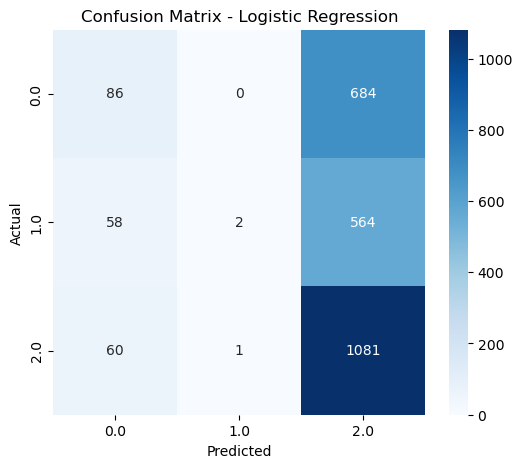

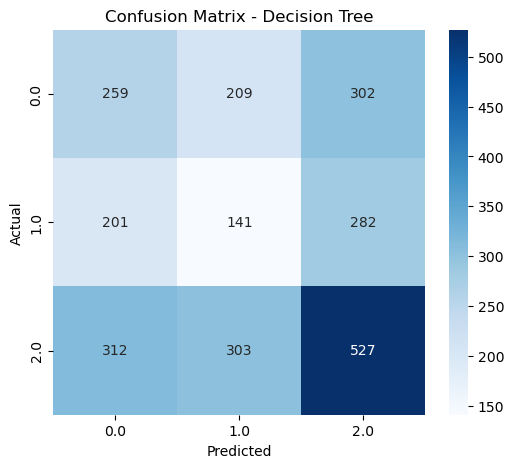

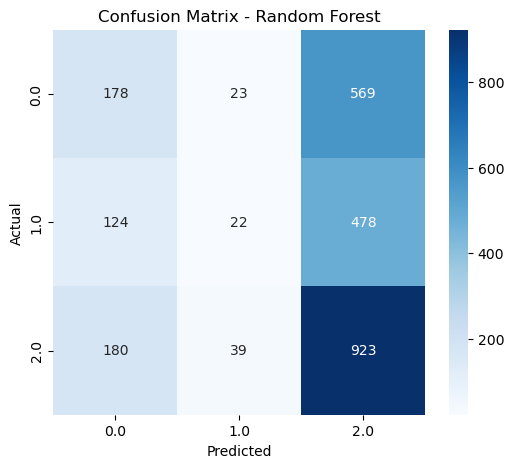

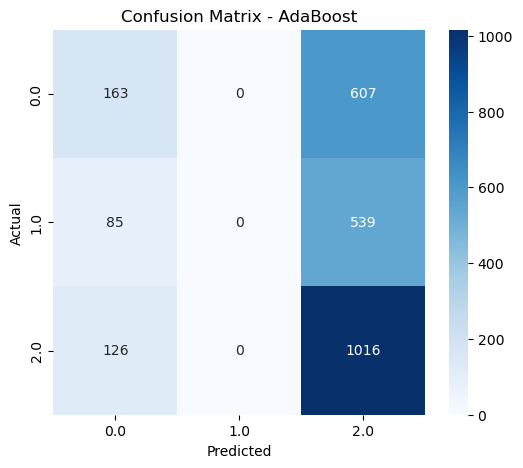

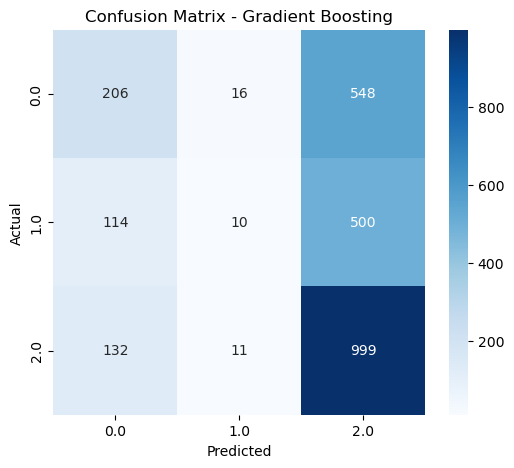

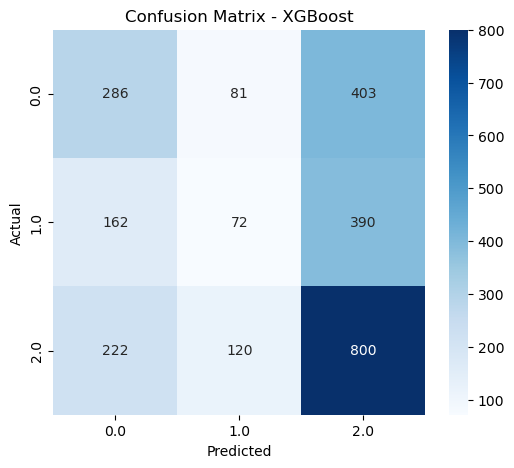

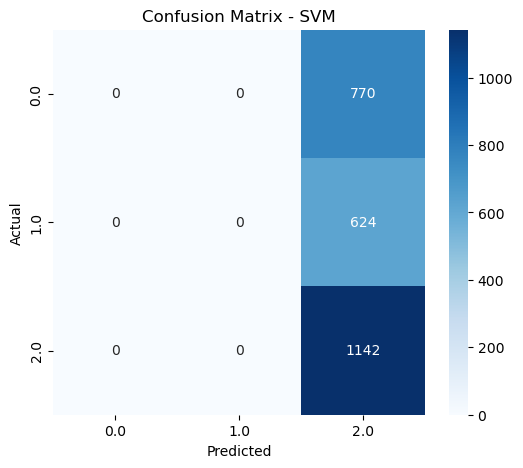

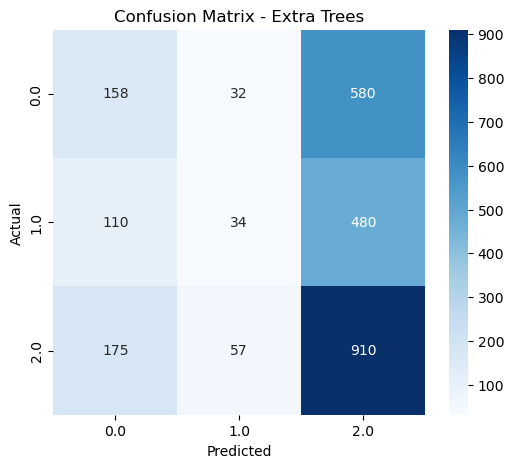

In [51]:
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
labels = sorted(y_test.unique())  # Get sorted class labels from your y_test

for model_name in models_list['Model']:
    conf_m = confusion_matrices.get(model_name)
    if conf_m is not None:
        plot_confusion_matrix(conf_m, labels, title=f"Confusion Matrix - {model_name}")
    else:
        print(f"No confusion matrix found for {model_name}")


#### saving best model (XGBoost) as pickle file for future implication

In [52]:
import pickle


# Save Gradient Boosting model
gboost_model = dict(models)["Gradient Boosting"]
with open(path_result+"/"+"best_model_GradientBoosting_Before_Game_Prediction_Historical_data.pkl", "wb") as f:
    pickle.dump(gboost_model, f)


### importance features by model

In [53]:
importance_df = pd.DataFrame(importance_feature)
importance_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,SVM,Extra Trees
0,"(away_total_saved_shots_h_rolling5, 0.04174398...","(awayTeamID, 0.06595336158175508)","(homeTeamID, 0.050498579512612524)","(awayTeamID, 0.377966617181964)","(awayTeamID, 0.22819524702054775)","(homeTeamID, 0.058926996)",None,"(homeTeamID, 0.04584628750721813)"
1,"(away_shotsOnTarget_h_rolling5, -0.04106010650...","(homeTeamID, 0.05664839810074291)","(awayTeamID, 0.04934018237334717)","(homeTeamID, 0.36598283835472856)","(homeTeamID, 0.2246333742523217)","(awayTeamID, 0.058707025)",None,"(awayTeamID, 0.04469259379359489)"
2,"(home_total_assists_a_rolling5, 0.035516383481...","(away_ppda_h_rolling5, 0.05348414195110806)","(away_ppda_h_rolling5, 0.046716483625048724)","(home_fouls_h_rolling5, 0.08461806372320956)","(home_ppda_a_rolling5, 0.04548092339978132)","(home_ppda_a_rolling5, 0.038154177)",None,"(home_fouls_h_rolling5, 0.03826444469407619)"
3,"(home_shotsOnTarget_h_rolling5, -0.03459679562...","(home_ppda_h_rolling5, 0.050862374893126984)","(home_ppda_h_rolling5, 0.046694792005447155)","(home_ppda_h_rolling5, 0.03706204769467255)","(home_ppda_h_rolling5, 0.03791034406386812)","(away_fouls_h_rolling5, 0.037789628)",None,"(away_total_key_passes_a_rolling5, 0.038212660..."
4,"(away_total_saved_shots_a_rolling5, -0.0264090...","(home_ppda_a_rolling5, 0.04896838450161899)","(home_ppda_a_rolling5, 0.046194812768435026)","(away_ppda_h_rolling5, 0.03259126462270193)","(away_ppda_h_rolling5, 0.03690862235543554)","(season, 0.03776176)",None,"(away_fouls_a_rolling5, 0.03807750302602706)"
5,"(away_deep_a_rolling5, 0.019797343856296702)","(home_fouls_h_rolling5, 0.04568203258886866)","(home_fouls_h_rolling5, 0.04117731661831143)","(home_total_assists_a_rolling5, 0.026527515014...","(home_deep_h_rolling5, 0.03473257903788645)","(home_total_assists_a_rolling5, 0.037090376)",None,"(home_deep_h_rolling5, 0.037961847979123525)"
6,"(home_corners_h_rolling5, -0.019550957752416036)","(away_fouls_a_rolling5, 0.04073658293664657)","(away_fouls_h_rolling5, 0.041012818386320316)","(home_ppda_a_rolling5, 0.022906738425513495)","(home_fouls_a_rolling5, 0.03004965209465892)","(home_ppda_h_rolling5, 0.037011325)",None,"(away_shotsOnTarget_h_rolling5, 0.037923577482..."
7,"(away_total_key_passes_a_rolling5, -0.01759765...","(away_total_key_passes_h_rolling5, 0.040717738...","(away_fouls_a_rolling5, 0.040650920195850995)","(home_fouls_a_rolling5, 0.0197371166390779)","(away_fouls_h_rolling5, 0.02728765319306945)","(away_ppda_h_rolling5, 0.036560655)",None,"(away_deep_a_rolling5, 0.03789582593202338)"
8,"(home_shots_h_rolling5, 0.014921094669796088)","(home_corners_h_rolling5, 0.03991975654262169)","(home_fouls_a_rolling5, 0.040519223124305226)","(away_deep_a_rolling5, 0.016504740884346704)","(home_fouls_h_rolling5, 0.026915749693993612)","(away_total_saved_shots_a_rolling5, 0.036363356)",None,"(home_fouls_a_rolling5, 0.03784556857480181)"
9,"(home_shotsOnTarget_a_rolling5, 0.012433407353...","(away_fouls_h_rolling5, 0.038806498357373716)","(away_total_key_passes_h_rolling5, 0.039794259...","(season, 0.01610305745931624)","(away_deep_h_rolling5, 0.023995606990771558)","(away_fouls_a_rolling5, 0.036153745)",None,"(away_total_key_passes_h_rolling5, 0.037791269..."


## Gradient Boosting provides the best results with 47% accuracy

### Hyperparameter Finetuning GradientBoostingClassifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Initialize model
gb = GradientBoostingClassifier()

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run it!
random_search.fit(X_train, y_train)

# Get the best model and performance
best_gb = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("✅ Best Parameters:", best_params)
print("🎯 Best F1 Score (CV):", best_score)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7, 'learning_rate': 0.1}
🎯 Best F1 Score (CV): 0.38250552119801745


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = best_gb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # use 'binary' for binary classification
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Store results
result = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1-score': f1
}

print("📊 Evaluation Metrics:")
for k, v in result.items():
    print(f"{k}: {v:.4f}")


📊 Evaluation Metrics:
Accuracy: 0.4661
Precision: 0.3995
Recall: 0.4037
f1-score: 0.3879


### The best parameters result got lowe F1 score and accuracy then the defult result 